# Default 8K 8Bit PCM (Read_audio)

- PyVoIP.read_audio -> | voip Network | format : byte, 8k 8bit | 160bytes | 160 samples | 0.02 sec |


### Gather buffer

- 0.32 sec을 쌓으려면? -? 160 sample * 16 =-> 2560 sample 

- 3.2 sec을 쌓으려면? --> 25600 samples

### Why gather 0.32 and 3.2 sec? (STFT, Spectrogram)

- Sbanana는 Signal processing을 통해 음성 신호를 Window length = 256, hop = 128의 Power spectrogram으로 변환하는데, 256 샘플로 윈도우를 설정하면 128개의 주파수 축이 생김. 

- 이 128의 주파수 축에 집중해야 하는 이유는, 8K 8Bit 기준 0.32sec, 3.2sec 샘플 수는 각각 2560, 25600인데 홉 사이즈 128 샘플로 나누어주게되면 정확히 나누어 떨어지기 떄문임. 계산을 하면 각각 20 * 128, 200 * 128의 스펙트로그램으로 변환이 됨.

- 즉, 8K 8Bit 신호 기준 2560, 25600샘플인 0.32sec, 3.2sec 단위로 Buffer를 쌓는 이유는 Sbanana 인퍼런스 전 신호 변환(spectrogram)에 사용하는 window size 256, hop 128 파라미터에 숫자가 딱 맞아 떨어지기 때문임.



# Audio signal Processing Reserach

- 목표 : 3.2sec 신호 패킷을 여러 Audio library로 변환해보면서 샘플 수를 비교. (왜 계산이 다르게 되는지? 원인 분석)

### 실험에 사용한 Audio Signal
- PyVoIp.read_audio를 통해 8K 8Bit PCM 패킷을 160개 버퍼에 쌓은 3.2sec 패킷

### 실험 대상
- Audio signal Processing library

### 실험 비교 대상
- 8K 8Bit 3.2sec 신호 패킷 샘플 수 -> 160 sample * 160 = 25600sample



In [82]:
from IPython.display import Audio, display

#raw 데이터
with open("output.raw", "rb") as f:
    raw_audio_data = f.read()

# Pywav

In [105]:
import pywav

def convert_to_wav(data_bytes, tmpFileName):
    wave_write = pywav.WavWrite(tmpFileName, 1, 8000, 8, 1)
    wave_write.write(data_bytes)
    wave_write.close()

    return open(tmpFileName, "rb")

convert_to_wav(raw_audio_data,'output_pywav.wav')

# WAV 파일 경로
audio_file_path = 'output_pywav.wav'

# WAV 파일을 재생합니다.
display(Audio(audio_file_path))

In [169]:
import numpy as np
import pywav
from IPython.display import Audio

def convert_to_wav_16bit(data_bytes, tmpFileName):
    # 8비트 데이터를 numpy 배열로 변환
    data_8bit = np.frombuffer(data_bytes, dtype=np.uint8)
    print("8비트 데이터 길이:", len(data_8bit))

    # 8비트 데이터를 16비트로 변환
    data_16bit = (data_8bit.astype(np.int16) - 128) * 256
    print("16비트 데이터 길이:", len(data_16bit))

    # 16비트 데이터를 WAV 파일로 저장
    wave_write = pywav.WavWrite(tmpFileName, 1, 8000, 16, 1)
    wave_write.write(data_16bit.tobytes())
    wave_write.close()

    return open(tmpFileName, "rb")

# 8비트 데이터를 16비트로 변환
converted_file = convert_to_wav_16bit(raw_audio_data, 'output_pywav_16bit.wav')

# WAV 파일 경로
audio_file_path = 'output_pywav_16bit.wav'

# WAV 파일을 재생합니다.
display(Audio(audio_file_path))

8비트 데이터 길이: 25600
16비트 데이터 길이: 25600


# pydub.AudioSegment

In [222]:
from pydub import AudioSegment

# 8-bit, 8kHz, mono로 raw 데이터를 AudioSegment로 변환

unit_8data = np.frombuffer(raw_audio_data, dtype=np.uint8)

audio_segment = AudioSegment(
    data=raw_audio_data,
    sample_width=1,  # 8-bit
    frame_rate=8000,  # 8kHz
    channels=1  # mono
)

# PCM 파일로 저장
audio_segment.export("output_pydub.wav", format="wav", parameters=["-acodec", "pcm_u8"])

# WAV 파일 경로
audio_file_path = 'output_pydub.wav'

# WAV 파일을 재생합니다.
display(Audio(audio_file_path))

In [145]:
from pydub import AudioSegment
from IPython.display import Audio

# 8-bit, 8kHz, mono로 raw 데이터를 AudioSegment로 변환
audio_segment = AudioSegment(
    data=raw_audio_data,
    sample_width=1,  # 8-bit
    frame_rate=8000,  # 8kHz
    channels=1  # mono
)

# sample_width를 2로 변경하여 16비트로 변환
audio_segment_16bit = audio_segment.set_sample_width(2)

# 16비트 PCM 파일로 저장
audio_segment_16bit.export("output_pydub_16bit.wav", format="wav", parameters=["-acodec", "pcm_s16le"])

# WAV 파일 경로
audio_file_path = 'output_pydub_16bit.wav'

# WAV 파일을 재생합니다.
display(Audio(audio_file_path))

# wave

In [42]:
import wave

with wave.open("output_wave.wav", "wb") as wave_file:
    wave_file.setnchannels(1)  # mono
    wave_file.setsampwidth(1)  # 8-bit
    wave_file.setframerate(8000)  # 8kHz
    wave_file.writeframes(raw_audio_data)
    
# WAV 파일 경로
audio_file_path = 'output_wave.wav'

# WAV 파일을 재생합니다.
display(Audio(audio_file_path))

In [118]:
import wave
import numpy as np

# 8비트 WAV 파일 열기
with wave.open("output_wave.wav", "rb") as wave_file:
    params = wave_file.getparams()
    audio_data = wave_file.readframes(params.nframes)

# 8비트 데이터를 16비트로 변환
audio_data_8bit = np.frombuffer(audio_data, dtype=np.uint8)
audio_data_16bit = (audio_data_8bit.astype(np.int16) - 128) * 256

# 16비트 WAV 파일 저장
with wave.open("output_wave_16bit.wav", "wb") as wave_file:
    wave_file.setnchannels(1)  # mono
    wave_file.setsampwidth(2)  # 16-bit
    wave_file.setframerate(8000)  # 8kHz
    wave_file.writeframes(audio_data_16bit.tobytes())

# 16비트 WAV 파일 경로
audio_file_path = 'output_wave_16bit.wav'

# 16비트 WAV 파일을 재생합니다.
display(Audio(audio_file_path))

# librosa

In [43]:
import librosa
import soundfile as sf
import numpy as np

# Load raw audio data with librosa
y = librosa.util.buf_to_float(raw_audio_data, n_bytes=1, dtype=np.uint8)

# Save as PCM WAV, 최신 버전에서 librosa의 ouput_wavfile 기능이 사라져 soundfile을 사용하게함.
sf.write("output_librosa.wav", y, 8000, subtype='PCM_U8')

# WAV 파일 경로
audio_file_path = 'output_librosa.wav'

# WAV 파일을 재생합니다.
display(Audio(audio_file_path))

In [123]:
import librosa
import soundfile as sf
import numpy as np

# Load raw audio data with librosa
# 이 단계에서 8비트 데이터를 float32로 정규화하여 불러옵니다
y = librosa.util.buf_to_float(raw_audio_data, n_bytes=1, dtype=np.uint8)

# 데이터를 16비트로 변환
y_16bit = (y * 32767).astype(np.int16)

# Save as PCM WAV with 16-bit
sf.write("output_librosa_16bit.wav", y_16bit, 8000, subtype='PCM_16')

# WAV 파일 경로
audio_file_path = 'output_librosa_16bit.wav'

# WAV 파일을 재생합니다.
from IPython.display import Audio
display(Audio(audio_file_path))

# scipy

In [44]:
from scipy.io import wavfile
import numpy as np

# Convert raw data to numpy array
audio_np = np.frombuffer(raw_audio_data, dtype=np.uint8)

# Save as PCM WAV
wavfile.write("output_scipy.wav", 8000, audio_np)

# WAV 파일 경로
audio_file_path = 'output_scipy.wav'

# WAV 파일을 재생합니다.
display(Audio(audio_file_path))

In [124]:
from scipy.io import wavfile
import numpy as np
from IPython.display import Audio

# Convert raw data to numpy array (8-bit)
audio_np_8bit = np.frombuffer(raw_audio_data, dtype=np.uint8)

# Convert 8-bit to 16-bit
audio_np_16bit = (audio_np_8bit.astype(np.int16) - 128) * 256

# Save as 16-bit PCM WAV
wavfile.write("output_scipy_16bit.wav", 8000, audio_np_16bit)

# WAV 파일 경로
audio_file_path = 'output_scipy_16bit.wav'

# WAV 파일을 재생합니다.
display(Audio(audio_file_path))

pydub sample count: 25600


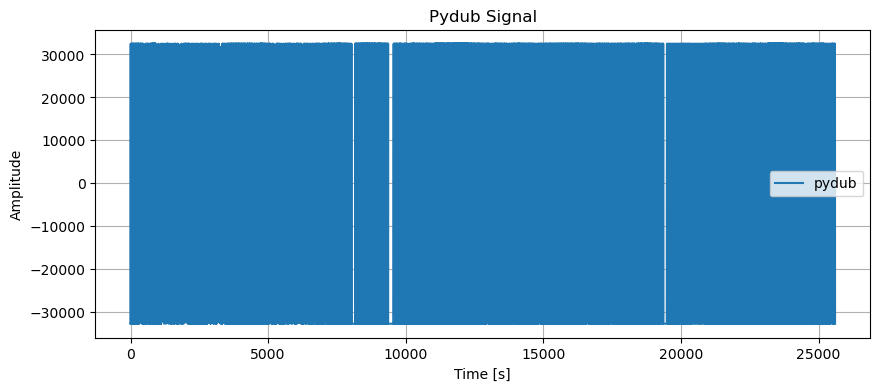

In [146]:
# Using pydub to get the sample count
audio_segment_samples = len(audio_segment_16bit.get_array_of_samples())
print("pydub sample count:", audio_segment_samples)

samples = np.frombuffer(audio_segment_16bit.get_array_of_samples(),dtype=np.int16)

# 시간축 생성 (8kHz 샘플링)
time = np.linspace(0, len(samples) / 8000, num=len(samples))

# 신호 시각화
plt.figure(figsize=(10, 4))
plt.plot(samples, label="pydub")
plt.title("Pydub Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()

pywav information: {'numchannels': 1, 'samplerate': 8000, 'byterate': 16000, 'bytespersample': 2, 'bitspersample': 16, 'samplelength': 51200, 'audioformat': 1}


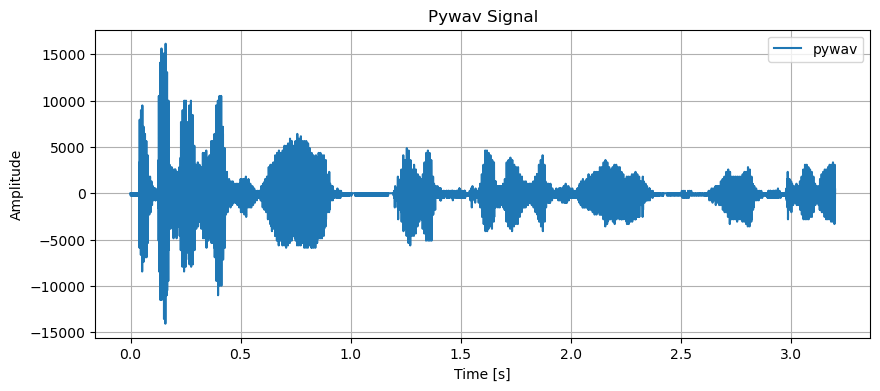

pydub sample count: 25600


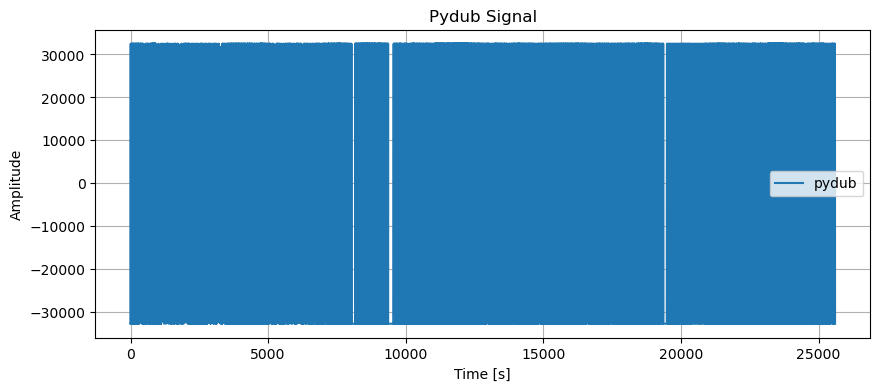

wave sample count: 25600


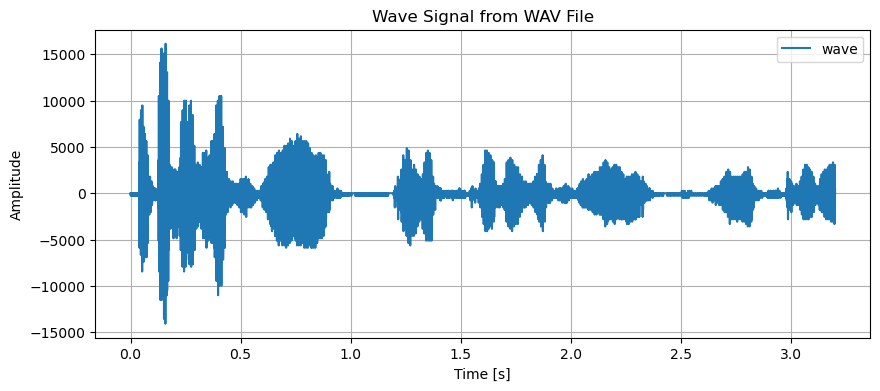

librosa sample count: 25600


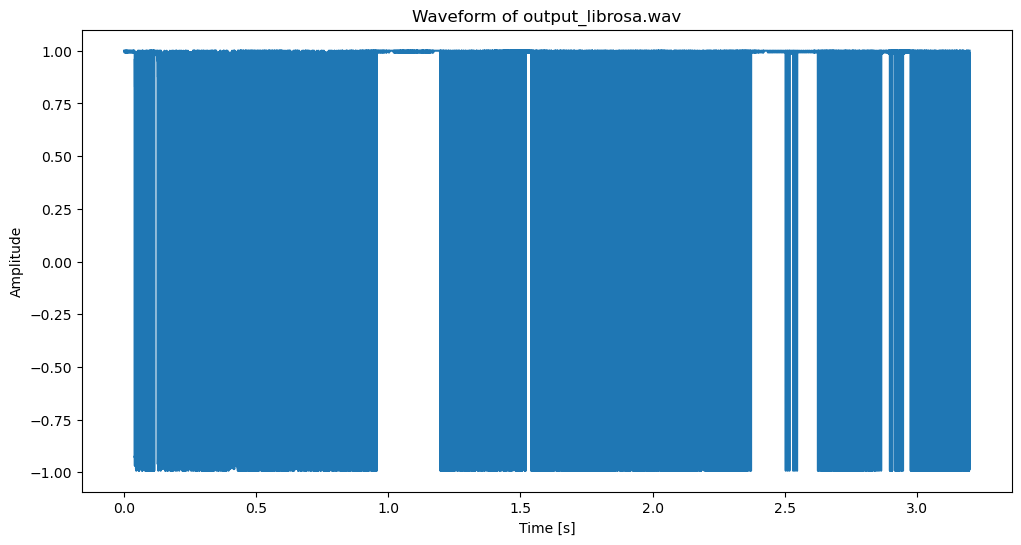

scipy sample count: 25600


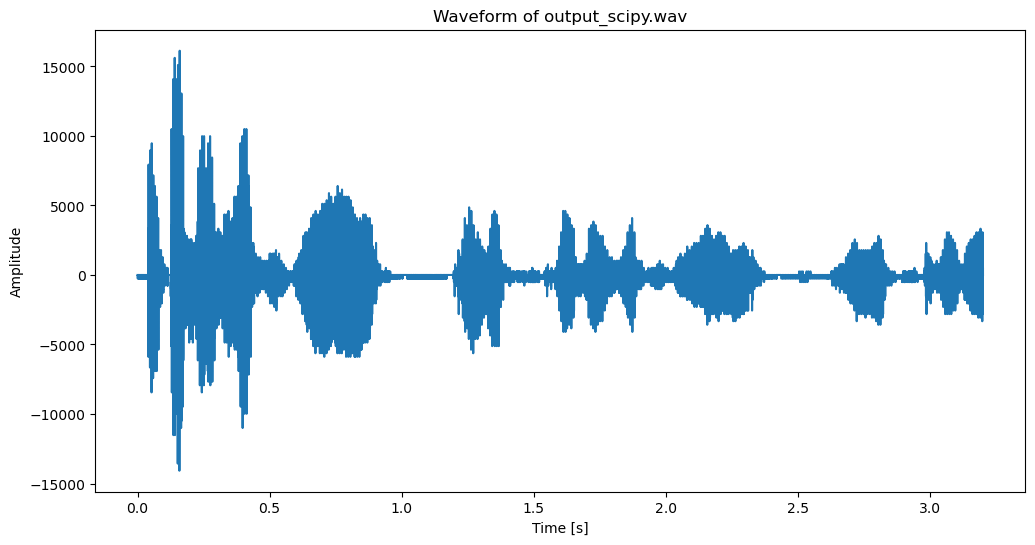

In [127]:

import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

#
wave_read = pywav.WavRead("output_pywav_16bit.wav")
print("pywav information:",wave_read.getparams())
data_bytes = wave_read.getdata()

# 데이터를 numpy 배열로 변환 (8-bit PCM이므로 np.uint8 사용)
signal = np.frombuffer(data_bytes, dtype=np.int16)

# 시간축 생성 (8kHz 샘플링)
time = np.linspace(0, len(signal) / 8000, num=len(signal))

# 신호 시각화
plt.figure(figsize=(10, 4))
plt.plot(time, signal, label="pywav")
plt.title("Pywav Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()


# Using pydub to get the sample count
audio_segment_samples = len(audio_segment_16bit.get_array_of_samples())
print("pydub sample count:", audio_segment_samples)

samples = np.frombuffer(audio_segment_16bit.get_array_of_samples(),dtype=np.int16)

# 시간축 생성 (8kHz 샘플링)
time = np.linspace(0, len(samples) / 8000, num=len(samples))

# 신호 시각화
plt.figure(figsize=(10, 4))
plt.plot(time, samples, label="pydub")
plt.title("Pydub Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()


# Using wave to get the sample count
with wave.open("output_wave_16bit.wav", "rb") as wave_file:
    wave_samples = wave_file.getnframes()
    print("wave sample count:", wave_samples)
    # 파일의 프레임 수 확인
    frames = wave_file.readframes(-1)
    # 8-bit 데이터로 변환
    samples = np.frombuffer(frames, dtype=np.int16)

# 시간축 생성 (8kHz 샘플링)
time = np.linspace(0, len(samples) / 8000, num=len(samples))

# 신호 시각화
plt.figure(figsize=(10, 4))
plt.plot(time, samples, label="wave")
plt.title("Wave Signal from WAV File")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()


# Using librosa to get the sample count
librosa_samples, _ = librosa.load("output_librosa_16bit.wav", sr=8000, mono=True)
print("librosa sample count:", len(librosa_samples))

audio_file_path = 'output_librosa_16bit.wav'

# 오디오 데이터를 librosa로 불러오기
y, sr = librosa.load(audio_file_path, sr=8000)

# 시간 축 데이터 생성
time = np.linspace(0, len(y) / sr, len(y))

# 파형 시각화
plt.figure(figsize=(12, 6))
plt.plot(time, y)
plt.title('Waveform of output_librosa.wav')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# Using scipy to get the sample count

sample_rate, scipy_samples = wavfile.read("output_scipy_16bit.wav")
print("scipy sample count:", len(scipy_samples))

# 시간 축 데이터 생성
time = np.linspace(0, len(scipy_samples) / sample_rate, num=len(scipy_samples))

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(time, scipy_samples)
plt.title('Waveform of output_scipy.wav')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

In [ ]:

import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

#
wave_read = pywav.WavRead("output_pywav.wav")
print("pywav information:",wave_read.getparams())
data_bytes = wave_read.getdata()

# 데이터를 numpy 배열로 변환 (8-bit PCM이므로 np.uint8 사용)
signal = np.frombuffer(data_bytes, dtype=np.uint8)

# 시간축 생성 (8kHz 샘플링)
time = np.linspace(0, len(signal) / 8000, num=len(signal))

# 신호 시각화
plt.figure(figsize=(10, 4))
plt.plot(time, signal, label="pywav")
plt.title("Pywav Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()


# Using pydub to get the sample count
audio_segment_samples = len(audio_segment.get_array_of_samples())
print("pydub sample count:", audio_segment_samples)

samples = np.frombuffer(audio_segment.get_array_of_samples(),dtype=np.uint8)

# 시간축 생성 (8kHz 샘플링)
time = np.linspace(0, len(samples) / 8000, num=len(samples))

# 신호 시각화
plt.figure(figsize=(10, 4))
plt.plot(time, samples, label="pydub")
plt.title("Pydub Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()


# Using wave to get the sample count
with wave.open("output_wave.wav", "rb") as wave_file:
    wave_samples = wave_file.getnframes()
    print("wave sample count:", wave_samples)
    # 파일의 프레임 수 확인
    frames = wave_file.readframes(-1)
    # 8-bit 데이터로 변환
    samples = np.frombuffer(frames, dtype=np.uint8)

# 시간축 생성 (8kHz 샘플링)
time = np.linspace(0, len(samples) / 8000, num=len(samples))

# 신호 시각화
plt.figure(figsize=(10, 4))
plt.plot(time, samples, label="wave")
plt.title("Wave Signal from WAV File")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()


# Using librosa to get the sample count
librosa_samples, _ = librosa.load("output_librosa.wav", sr=8000, mono=True)
print("librosa sample count:", len(librosa_samples))

audio_file_path = 'output_librosa.wav'

# 오디오 데이터를 librosa로 불러오기
y, sr = librosa.load(audio_file_path, sr=8000)

# 시간 축 데이터 생성
time = np.linspace(0, len(y) / sr, len(y))

# 파형 시각화
plt.figure(figsize=(12, 6))
plt.plot(time, y)
plt.title('Waveform of output_librosa.wav')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# Using scipy to get the sample count

sample_rate, scipy_samples = wavfile.read("output_scipy.wav")
print("scipy sample count:", len(scipy_samples))

# 시간 축 데이터 생성
time = np.linspace(0, len(scipy_samples) / sample_rate, num=len(scipy_samples))

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(time, scipy_samples)
plt.title('Waveform of output_scipy.wav')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# 인퍼런스 테스트

# pywav 인퍼런스

In [ ]:
import numpy as np
import pywav
from IPython.display import Audio

def convert_to_wav_16bit(data_bytes, tmpFileName):
    # 8비트 데이터를 numpy 배열로 변환
    data_8bit = np.frombuffer(data_bytes, dtype=np.uint8)
    print("8비트 데이터 길이:", len(data_8bit))

    # 8비트 데이터를 16비트로 변환
    data_16bit = (data_8bit.astype(np.int16) - 128) * 256
    print("16비트 데이터 길이:", len(data_16bit))

    # 16비트 데이터를 WAV 파일로 저장
    wave_write = pywav.WavWrite(tmpFileName, 1, 8000, 16, 1)
    wave_write.write(data_16bit.tobytes())
    wave_write.close()

    return open(tmpFileName, "rb")

# 8비트 데이터를 16비트로 변환
converted_file = convert_to_wav_16bit(raw_audio_data, 'output_pywav_16bit.wav')

# WAV 파일 경로
audio_file_path = 'output_pywav_16bit.wav'

# WAV 파일을 재생합니다.
display(Audio(audio_file_path))

In [ ]:
wave_read = pywav.WavRead("output_pywav.wav")
print('pywav 8비트 인퍼런스')
print("pywav information:",wave_read.getparams())
data_bytes = wave_read.getdata()

# 데이터를 numpy 배열로 변환 (8-bit PCM이므로 np.uint8 사용)
signal = np.frombuffer(data_bytes, dtype=np.uint8)

stt_text = do_prediction(signal)

print(stt_text)
print('====='*10)
##################################################################
print('pywav 16비트 인퍼런스')
wave_read = pywav.WavRead("output_pywav_16bit.wav")
print("pywav information:",wave_read.getparams())
data_bytes = wave_read.getdata()

# 데이터를 numpy 배열로 변환 (8-bit PCM이므로 np.uint8 사용)
signal = np.frombuffer(data_bytes, dtype=np.int16)

stt_text = do_prediction(signal)

print(stt_text)
print('====='*10)

pywav 8비트 인퍼런스
pywav information: {'numchannels': 1, 'samplerate': 8000, 'byterate': 8000, 'bytespersample': 1, 'bitspersample': 8, 'samplelength': 25600, 'audioformat': 1}
[갖다 날알려주세요 영업시간 알려주세요 영업시가]
pywav 16비트 인퍼런스
pywav information: {'numchannels': 1, 'samplerate': 8000, 'byterate': 16000, 'bytespersample': 2, 'bitspersample': 16, 'samplelength': 51200, 'audioformat': 1}
[갖다 날알려주세요 영업시간 알려주세요 영업시가]


# pydub.AudioSegements 인퍼런스

- AudioSegment set_sample_width(2)로 16비트로 강제로 늘리면 16비트로 제대로 변환하지 않는 문제를 발견.

In [ ]:
print('pydub 8비트 인퍼런스')
pcm8_audio = AudioSegment.from_file('output_pydub.wav', format="wav")
signal = np.frombuffer(pcm8_audio.get_array_of_samples(), dtype=np.uint8)

stt_text = do_prediction(signal)

print(stt_text)
print('====='*10)

print('pydub 16비트 인퍼런스')
pcm16_audio = AudioSegment.from_file('output_pydub_16bit.wav', format="wav")
signal = np.frombuffer(pcm16_audio.get_array_of_samples(), dtype=np.int16)

stt_text = do_prediction(signal)

print(stt_text)
print('====='*10)


pydub 8비트 인퍼런스
[갖다 날알려주세요 영업시간 알려주세요 영업시가]
pydub 16비트 인퍼런스
[< ]


# wave 인퍼런스

In [ ]:
print('wave 8비트 인퍼런스')
# Using wave to get the sample count
with wave.open("output_wave.wav", "rb") as wave_file:
    wave_samples = wave_file.getnframes()
    print("wave sample count:", wave_samples)
    # 파일의 프레임 수 확인
    frames = wave_file.readframes(-1)
    # 8-bit 데이터로 변환
    samples = np.frombuffer(frames, dtype=np.uint8)
    
stt_text = do_prediction(samples)

print(stt_text)
print('====='*10)


print('wave 16비트 인퍼런스')
# Using wave to get the sample count
with wave.open("output_wave_16bit.wav", "rb") as wave_file:
    wave_samples = wave_file.getnframes()
    print("wave sample count:", wave_samples)
    # 파일의 프레임 수 확인
    frames = wave_file.readframes(-1)
    # 8-bit 데이터로 변환
    samples = np.frombuffer(frames, dtype=np.int16)

stt_text = do_prediction(samples)    


print(stt_text)
print('====='*10)

wave 8비트 인퍼런스
wave sample count: 25600
[갖다 날알려주세요 영업시간 알려주세요 영업시가]
wave 16비트 인퍼런스
wave sample count: 25600
[갖다 날알려주세요 영업시간 알려주세요 영업시가]


# librosa 인퍼런스

- librosa 라이브러리에서 util.buf_to_float를 사용해 8비트 unit8로 저장해도 자동으로 float 32 -1 ~ 1범위로 정규화가 됨.
- librosa 버전이 달라지면서 output_wavfile 기능이 사라져 soundfile로 저장하는 것을 권장함.
- 16비트로 변환 시 정규화가 돼있기 때문에 16비트 변환이 어려움. 

y = librosa.util.buf_to_float(raw_audio_data, n_bytes=1, dtype=np.uint8)

sf.write("output_librosa.wav", y, 8000, subtype='PCM_U8')

y_16bit = (y * 32767).astype(np.int16) # 정규화로 인한 16비트 변환 과정

sf.write("output_librosa_16bit.wav", y_16bit, 8000, subtype='PCM_16')

In [212]:
print('librosa 8비트 인퍼런스')
# 오디오 데이터를 librosa로 불러오기
y, sr = librosa.load('output_librosa.wav', sr=8000)

#이미 array 배열인 상태 float32로 정규화해서 가져옴
samples = np.frombuffer(y, dtype=np.uint8)
#samples = np.array(y.astype(np.uint8))
print(samples.dtype)
stt_text = do_prediction(samples)

print(stt_text)
print('====='*10)

print('librosa float 32 정규화 인퍼런스')
# 오디오 데이터를 librosa로 불러오기
y, sr = librosa.load('output_librosa.wav', sr=8000)

print(y.dtype)
stt_text = do_prediction(y)

print(stt_text)
print('====='*10)

print('librosa 16비트 인퍼런스')
y, sr = librosa.load('output_librosa_16bit.wav', sr=8000)

print(y.dtype)
# samples = np.frombuffer(y, dtype=np.int16)

stt_text = do_prediction(y)

print(stt_text)

librosa 8비트 인퍼런스
uint8
[]
librosa float 32 정규화 인퍼런스
float32
[아 연 주세요 연락시처화 알려주어세요 []
librosa 16비트 인퍼런스
float32
[세세 ]


# numpy & scipy 인퍼런스 



In [218]:
print('numpy & scipy 8비트 인퍼런스')
sample_rate, scipy_samples = wavfile.read("output_scipy.wav")

stt_text = do_prediction(scipy_samples)

print(stt_text)
print('====='*10)

print('numpy & scipy 8비트 인퍼런스')
sample_rate, scipy_samples = wavfile.read("output_scipy.wav")

samples = np.frombuffer(scipy_samples,dtype=np.uint8)
stt_text = do_prediction(samples)

print(stt_text)
print('====='*10)

print('numpy & scipy 16비트 인퍼런스')
sample_rate, scipy_samples = wavfile.read("output_scipy_16bit.wav")

stt_text = do_prediction(scipy_samples)

print(stt_text)
print('====='*10)

print('numpy & scipy 16비트 인퍼런스')
sample_rate, scipy_samples = wavfile.read("output_scipy_16bit.wav")

samples = np.frombuffer(scipy_samples,dtype=np.int16)
stt_text = do_prediction(samples)

print(stt_text)
print('====='*10)

numpy & scipy 8비트 인퍼런스
[갖다 날알려주세요 영업시간 알려주세요 영업시가]
numpy & scipy 8비트 인퍼런스
[갖다 날알려주세요 영업시간 알려주세요 영업시가]
numpy & scipy 16비트 인퍼런스
[갖다 날알려주세요 영업시간 알려주세요 영업시가]
numpy & scipy 16비트 인퍼런스
[갖다 날알려주세요 영업시간 알려주세요 영업시가]
